# Imports

In [1]:
# To run all the expressions in each cell. 
# To return to the default behavior, write: InteractiveShell.ast_node_interactivity = "last_expr"

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Acquisition and first inspection of the main database

Let's import the database, preview its first few rows and inspect the columns.

In [3]:
df = pd.read_csv('Deaths_db.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346342 entries, 0 to 346341
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Year                            346342 non-null  int64  
 1   WEEK                            346342 non-null  int64  
 2   Week Ending Date                346342 non-null  object 
 3   REGION                          346342 non-null  int64  
 4   State                           340300 non-null  object 
 5   City                            340300 non-null  object 
 6   Pneumonia and Influenza Deaths  343058 non-null  float64
 7   All Deaths                      344871 non-null  float64
 8   <1 year (all cause deaths)      338953 non-null  float64
 9   1-24 years (all cause deaths)   339374 non-null  float64
 10  25-44 years                     342711 non-null  float64
 11  45-64 years (all cause deaths)  344662 non-null  float64
 12  65+ years (all c

*The columns of the database are named inconsistently; also, very long names makes it boring to refer to. 
RENAME them.*

*Moreover, change the data type of entries in a bunch of columns. I prefer to have the first six columns object (i.e. strings).*

In [4]:
dict_columns = {'Year':'year', 'WEEK':'week', 'Week Ending Date':'week_end', 'REGION':'region', 'State':'state', 
                'City':'city', 'Pneumonia and Influenza Deaths':'PI_deaths', 'All Deaths':'all_deaths', 
                '<1 year (all cause deaths)':'0_deaths', '1-24 years (all cause deaths)':'1-24_deaths', 
                '25-44 years':'25-44_deaths', '45-64 years (all cause deaths)':'45-64_deaths', 
                '65+ years (all cause deaths)':'65+_deaths'};
df.rename(columns=dict_columns, inplace=True)

df[['year', 'week', 'region']] = df[['year', 'week', 'region']].astype('object')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346342 entries, 0 to 346341
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          346342 non-null  object 
 1   week          346342 non-null  object 
 2   week_end      346342 non-null  object 
 3   region        346342 non-null  object 
 4   state         340300 non-null  object 
 5   city          340300 non-null  object 
 6   PI_deaths     343058 non-null  float64
 7   all_deaths    344871 non-null  float64
 8   0_deaths      338953 non-null  float64
 9   1-24_deaths   339374 non-null  float64
 10  25-44_deaths  342711 non-null  float64
 11  45-64_deaths  344662 non-null  float64
 12  65+_deaths    344845 non-null  float64
dtypes: float64(7), object(6)
memory usage: 34.4+ MB


There are 6042 rows of the DataFrame with a NaN in either the state or the city column (in fact both, as shown below). Let's create a new DataFrame only including those data. When mortality data are present (i.e. it isn't just a row of NaN's), we might be able to guess a posteriori what city do those data belong to.

In [5]:
df_nocity = df[df.city.isna()]

df_nocity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6042 entries, 96790 to 302205
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          6042 non-null   object 
 1   week          6042 non-null   object 
 2   week_end      6042 non-null   object 
 3   region        6042 non-null   object 
 4   state         0 non-null      object 
 5   city          0 non-null      object 
 6   PI_deaths     5982 non-null   float64
 7   all_deaths    5982 non-null   float64
 8   0_deaths      5982 non-null   float64
 9   1-24_deaths   5982 non-null   float64
 10  25-44_deaths  5982 non-null   float64
 11  45-64_deaths  5982 non-null   float64
 12  65+_deaths    5982 non-null   float64
dtypes: float64(7), object(6)
memory usage: 660.8+ KB


*Now restrict the main DataFrame to the rows with non-missing values of 'state' and 'city'.*

In [6]:
df = df[df.city.notna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340300 entries, 0 to 346341
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          340300 non-null  object 
 1   week          340300 non-null  object 
 2   week_end      340300 non-null  object 
 3   region        340300 non-null  object 
 4   state         340300 non-null  object 
 5   city          340300 non-null  object 
 6   PI_deaths     337076 non-null  float64
 7   all_deaths    338889 non-null  float64
 8   0_deaths      332971 non-null  float64
 9   1-24_deaths   333392 non-null  float64
 10  25-44_deaths  336729 non-null  float64
 11  45-64_deaths  338680 non-null  float64
 12  65+_deaths    338863 non-null  float64
dtypes: float64(7), object(6)
memory usage: 36.3+ MB


Ok, now we are left with a DataFrame having missing values only in the numeric columns. We will investigate it further in what follows.

### A consistency check

Consistency check: is the all_deaths column the sum of the 0_deaths, ..., 65+_deaths?

In [7]:
df['check'] = df['all_deaths'] - df[['0_deaths', '1-24_deaths', '25-44_deaths', '45-64_deaths', '65+_deaths']].sum(axis=1, skipna=False)

checksum = pd.Series(df.check.value_counts(dropna=False))

The series indices here are always integers: I would like them to be converted to int and then to strings. Hence the following function.

In [8]:
def make_index_str(df):
    index_dict = {}
    for c in df.index:
        try:
            index_dict[c] = str(int(c))
        except ValueError:
            index_dict[c] = 'NaN'
    df = df.rename(index_dict)
    return df

checksum = make_index_str(checksum)
checksum.index
checksum

Index([  '0',   nan,   '1',   '2',   '3',   '4',   '5',   '6',   '7',   '8',
         '9',  '10',  '11',  '12',  '13',  '14',  '15',  '17',  '18',  '16',
        '22',  '20',  '21',  '19',  '30',  '29',  '26',  '25',  '28',  '24',
        '32',  '35',  '27',  '87',  '33',  '65',  '71',  '38',  '44',  '48',
        '37',  '31',  '52',  '58',  '39',  '61',  '41',  '85',  '90',  '46',
        '47',  '95',  '59', '110', '128', '100',  '72', '114',  '70'],
      dtype='object')

0      322927
NaN      9348
1        5095
2        1222
3         536
4         251
5         162
6         134
7          94
8          83
9          70
10         59
11         43
12         40
13         36
14         29
15         26
17         19
18         14
16         13
22         11
20         10
21          8
19          7
30          6
29          5
26          4
25          4
28          4
24          4
32          3
35          2
27          2
87          2
33          2
65          2
71          1
38          1
44          1
48          1
37          1
31          1
52          1
58          1
39          1
61          1
41          1
85          1
90          1
46          1
47          1
95          1
59          1
110         1
128         1
100         1
72          1
114         1
70          1
Name: check, dtype: int64

Cool. It looks like - but for a few cases where relatively large discrepancies are present, to be investigated further - the numbers add up quite alright. Of course the elephant in the room is the non-negligible amount of NaN's.

To get a better idea of where the problem might lie, let's split the database into several different ones, either by year or by city. 
We'll create dictionaries of DataFrames.

# Splitting the main database by year/city

This is useful to have smaller, more manageable DataFrames to manipulate; moreover, a natural thing to do will be to compute statistics of interest by year, as well as time series from databases pertaining to single cities.

We'll write functions generating dictionaries of databases, splitting the main one across different values found in a given column.

In [9]:
df['year'].unique()
df['city'].unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
      dtype=object)

array(['Boston', 'Hartford', 'Bridgeport', 'Cambridge', 'Somerville',
       'Allentown', 'Fall River', 'Camden', 'Yonkers', 'Lowell', 'Gary',
       'South Bend', 'Youngstown', 'Des Moines', 'Kansas City', 'Lincoln',
       'Lynn', 'New Bedford', 'New Haven', 'Providence', 'Springfield',
       'Waterbury', 'Worcester', 'Albany', 'Buffalo', 'Elizabeth', 'Erie',
       'Jersey City', 'New York', 'Newark', 'Paterson', 'Philadelphia',
       'Pittsburgh', 'Reading', 'Rochester', 'Schenectady', 'Scranton',
       'Syracuse', 'Trenton', 'Utica', 'Akron', 'Canton', 'Chicago',
       'Cincinnati', 'Cleveland', 'Columbus', 'Dayton', 'Detroit',
       'Evansville', 'Fort Wayne', 'Grand Rapids', 'Indianapolis',
       'Lansing', 'Milwaukee', 'Peoria', 'Rockford', 'Toledo', 'Duluth',
       'Minneapolis', 'Omaha', 'Saint Louis', 'Saint Paul', 'Wichita',
       'Atlanta', 'Wilimington', 'Baltimore', 'Charlotte', 'Jacksonville',
       'Birmingham', 'Baton Rouge', 'Corpus Christi', 'New Orleans',


In [10]:
def split_by(df, col):
    dictionary = {}
    col_setofvalues = df[col].unique()
    for val in col_setofvalues:
        dictionary[val] = df[df[col] == val]
    return dictionary

dict_year = split_by(df, 'year')
dict_city = split_by(df, 'city')

For example...

In [11]:
dict_year[1988]
dict_city['Chicago']

,year,week,week_end,region,state,city,PI_deaths,all_deaths,0_deaths,1-24_deaths,25-44_deaths,45-64_deaths,65+_deaths,check
1357,1988,1,01/09/1988,1,MA,Boston,27.0,197.0,3.0,6.0,16.0,51.0,121.0,0.0
1358,1988,2,01/16/1988,1,MA,Boston,24.0,174.0,3.0,5.0,9.0,37.0,120.0,0.0
1359,1988,3,01/23/1988,1,MA,Boston,22.0,173.0,8.0,7.0,9.0,37.0,112.0,0.0
1360,1988,4,01/30/1988,1,MA,Boston,27.0,196.0,9.0,3.0,18.0,47.0,119.0,0.0
1361,1988,5,02/06/1988,1,MA,Boston,19.0,196.0,8.0,8.0,19.0,36.0,125.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344889,1988,48,12/03/1988,9,WA,Tacoma,3.0,35.0,0.0,0.0,2.0,6.0,27.0,0.0
344890,1988,49,12/10/1988,9,WA,Tacoma,5.0,51.0,1.0,4.0,1.0,9.0,36.0,0.0
344891,1988,50,12/17/1988,9,WA,Tacoma,2.0,42.0,0.0,0.0,4.0,10.0,28.0,0.0
344892,1988,51,12/24/1988,9,WA,Tacoma,5.0,49.0,0.0,0.0,3.0,11.0,35.0,0.0


,year,week,week_end,region,state,city,PI_deaths,all_deaths,0_deaths,1-24_deaths,25-44_deaths,45-64_deaths,65+_deaths,check
104852,1962,1,01/06/1962,3,IL,Chicago,51.0,859.0,62.0,29.0,62.0,266.0,440.0,0.0
104853,1962,2,01/13/1962,3,IL,Chicago,40.0,839.0,48.0,22.0,59.0,225.0,485.0,0.0
104854,1962,3,01/20/1962,3,IL,Chicago,55.0,894.0,58.0,23.0,74.0,260.0,479.0,0.0
104855,1962,4,01/27/1962,3,IL,Chicago,45.0,877.0,54.0,30.0,69.0,247.0,477.0,0.0
104856,1962,5,02/03/1962,3,IL,Chicago,45.0,847.0,49.0,29.0,52.0,241.0,476.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107683,2016,35,09/03/2016,3,IL,Chicago,12.0,251.0,3.0,10.0,18.0,78.0,142.0,0.0
107684,2016,36,09/10/2016,3,IL,Chicago,18.0,335.0,4.0,13.0,38.0,95.0,185.0,0.0
107685,2016,37,09/17/2016,3,IL,Chicago,18.0,282.0,3.0,11.0,24.0,59.0,185.0,0.0
107686,2016,38,09/24/2016,3,IL,Chicago,21.0,255.0,3.0,7.0,21.0,64.0,160.0,0.0


Let's now take a look at the DataFrames by year and by city. The following functions allow me to check how many rows per year/city contain *any* NaN and how many contain *all* NaNs.

**Note for improvements**: I could tweak them to display the information in a better form, e.g. percentage of rows containing NaNs over total rows and percentage of all-NaN-rows over total of rows containing NaNs. And sort them to better highlight which DataFrames by year and by city will potentially be more troublesome. 

In [12]:
def how_many_nan_per_year():
    for y in range(1965, 2017):
        dy = dict_year[y]
        any_number_of_nan = dy[dy.isnull().any(axis=1)]
        all_nan = any_number_of_nan[any_number_of_nan.iloc[:,6:].isnull().all(axis=1)]
        print('The DataFrame for year {0} has {1} rows.'.format(y, len(dy.index)))
        print('The number of rows with any NaNs is {}.'.format(len(any_number_of_nan.index)))
        print('The number of rows with all NaNs is {}. \n'.format(len(all_nan.index)))

def how_many_nan_per_city():
    for c in df['city'].unique():
        dc = dict_city[c]
        any_number_of_nan = dc[dc.isnull().any(axis=1)]
        all_nan = any_number_of_nan[any_number_of_nan.iloc[:,6:].isnull().all(axis=1)]
        print('The DataFrame for {0} has {1} rows.'.format(c, len(dc.index)))
        print('The number of rows with any NaNs is {}.'.format(len(any_number_of_nan.index)))
        print('The number of rows with all NaNs is {}. \n'.format(len(all_nan.index)))

In [13]:
how_many_nan_per_year()

print('--------------------------------------------------------------------------------------------------------- \n'*5)

how_many_nan_per_city()

The DataFrame for year 1965 has 6084 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1966 has 6084 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1967 has 6084 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1968 has 6136 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1969 has 6254 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1970 has 6136 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1971 has 6136 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame for year 1972 has 6136 rows.
The number of rows with any NaNs is 0.
The number of rows with all NaNs is 0. 

The DataFrame fo

The DataFrame for Buffalo has 2857 rows.
The number of rows with any NaNs is 23.
The number of rows with all NaNs is 10. 

The DataFrame for Elizabeth has 2857 rows.
The number of rows with any NaNs is 202.
The number of rows with all NaNs is 17. 

The DataFrame for Erie has 2855 rows.
The number of rows with any NaNs is 115.
The number of rows with all NaNs is 0. 

The DataFrame for Jersey City has 2856 rows.
The number of rows with any NaNs is 189.
The number of rows with all NaNs is 6. 

The DataFrame for New York has 2857 rows.
The number of rows with any NaNs is 1.
The number of rows with all NaNs is 1. 

The DataFrame for Newark has 2855 rows.
The number of rows with any NaNs is 91.
The number of rows with all NaNs is 10. 

The DataFrame for Paterson has 2852 rows.
The number of rows with any NaNs is 199.
The number of rows with all NaNs is 27. 

The DataFrame for Philadelphia has 2656 rows.
The number of rows with any NaNs is 6.
The number of rows with all NaNs is 6. 

The DataF

The DataFrame for Fresno has 2854 rows.
The number of rows with any NaNs is 40.
The number of rows with all NaNs is 11. 

The DataFrame for Glendale has 2857 rows.
The number of rows with any NaNs is 64.
The number of rows with all NaNs is 20. 

The DataFrame for Honolulu has 2857 rows.
The number of rows with any NaNs is 79.
The number of rows with all NaNs is 2. 

The DataFrame for Long Beach has 2854 rows.
The number of rows with any NaNs is 54.
The number of rows with all NaNs is 6. 

The DataFrame for Los Angeles has 2857 rows.
The number of rows with any NaNs is 20.
The number of rows with all NaNs is 20. 

The DataFrame for Pasadena has 2857 rows.
The number of rows with any NaNs is 199.
The number of rows with all NaNs is 17. 

The DataFrame for Portland has 2855 rows.
The number of rows with any NaNs is 16.
The number of rows with all NaNs is 5. 

The DataFrame for San Diego has 2856 rows.
The number of rows with any NaNs is 6.
The number of rows with all NaNs is 2. 

The Data

Good news: the number of rows containing NaNs seems to be quite limited counting both per year and by city. Moreover, the fraction of those rows that *only* contain NaNs - and therefore look unsalvageable - is usually quite low, although there are exceptions (e.g. Atlanta, New Orleans). It should be noted, however, that missing values only appear between 1991 and 2012, so that their influence is somewhat bigger than if they were homogeneously spread across the whole DataFrame.

Bottom line: discarding all-NaN rows shouldn't compromise the quality of any sub-DataFrame and I should also be able to replace some of the NaNs in a meaningful way. In particular, out of the rows with missing values, assuming that the total number of deaths is reliable,
* a good number of them just has a single NaN, which can then be inferred so that the total number of deaths is achieved;
* some other rows lack more than one value, but the numbers of deaths per age group that appear already sum up to the total number of deaths, hence the NaN's can be replaced with 0s;
* some other rows have multiple NaN's, which cannot be unambiguously determined: one strategy would be to replace all of them but one with the mean value in that city over the last n months/years and the final with what's required to achieve the total number of deaths (do this on the rightmost NaN, as it's likely to have a higher number of deaths among older sectors of the population and this can better accomodate a fluctuation that might otherwise look weird in the first columns -- if in a particular week, say, 5 toddlers died, when the average number is 0.8);
* finally there are rows with all NaN's, which are useless and can be discarded: from the looks of it I won't be losing more than a few data points (out of 52) per year, which sounds reasonable.

# Filling in the missing values when possible and discarding useless rows

# Plotting the heck out of these DataFrames!

Use one specific sub-DataFrame from dict_year and dict_city. Let's drop the *check* column.

In [14]:
dy = dict_year[1976].drop(columns=['check'])
dc = dict_city['Albuquerque'].drop(columns=['check'])

### Plotting total deaths per week in a year, possibly excluding some columns

In [15]:
def plot_total_deaths_per_week_by_year(year, exclude_age=[]):
    dy = dict_year[year].drop(columns=['check']).drop(columns=exclude_age).groupby(['week']).sum()
    fig, ax = plt.subplots()
    
    fig.set_size_inches(15,5)
    for col in dy.columns:
        if col == 'all_deaths':
            ax.plot(dy.index, dy[col], linestyle='-', color='black', label=col)
        elif col == 'PI_deaths':
            ax.plot(dy.index, dy[col], marker='', linestyle='-', color='red', label=col)
        else:
            ax.plot(dy.index, dy[col], linestyle='--', marker='.', label=col)

    ax.set(title='Number of deaths in the year {}'.format(year), xlabel='Week number', ylabel='Number of deaths')
    plt.yscale('log')
    fig.legend(loc='right')
    
    plt.show()

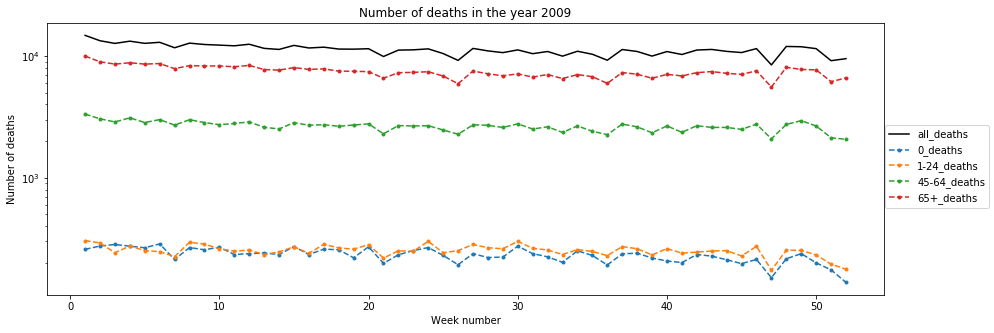

In [16]:
plot_total_deaths_per_week_by_year(2009, ['PI_deaths', '25-44_deaths'])

In [17]:
def plot_total_deaths_per_week_by_year_compare(years=[], exclude_age=[]):
    if years == []:
        print('The argument "years" must be a non-empty list.')
    else:
        fig, ax = plt.subplots(len(years),1, sharey=True)
        fig.set_size_inches(15,5*len(years))
        
        for y in range(len(years)):
            dy = dict_year[years[y]].drop(columns=['check']).drop(columns=exclude_age).groupby(['week']).sum()
            for col in dy.columns:
                if col == 'all_deaths':
                    ax[y].plot(dy.index, dy[col], linestyle='-', color='black', label=col)
                elif col == 'PI_deaths':
                    ax[y].plot(dy.index, dy[col], marker='', linestyle='-', color='red', label=col)
                else:
                    ax[y].plot(dy.index, dy[col], linestyle='--', marker='.', label=col)

            ax[y].set(title='Number of deaths in the year {}'.format(years[y]), xlabel='Week number', ylabel='Number of deaths')
            
        plt.yscale('log')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='right')

        plt.show()

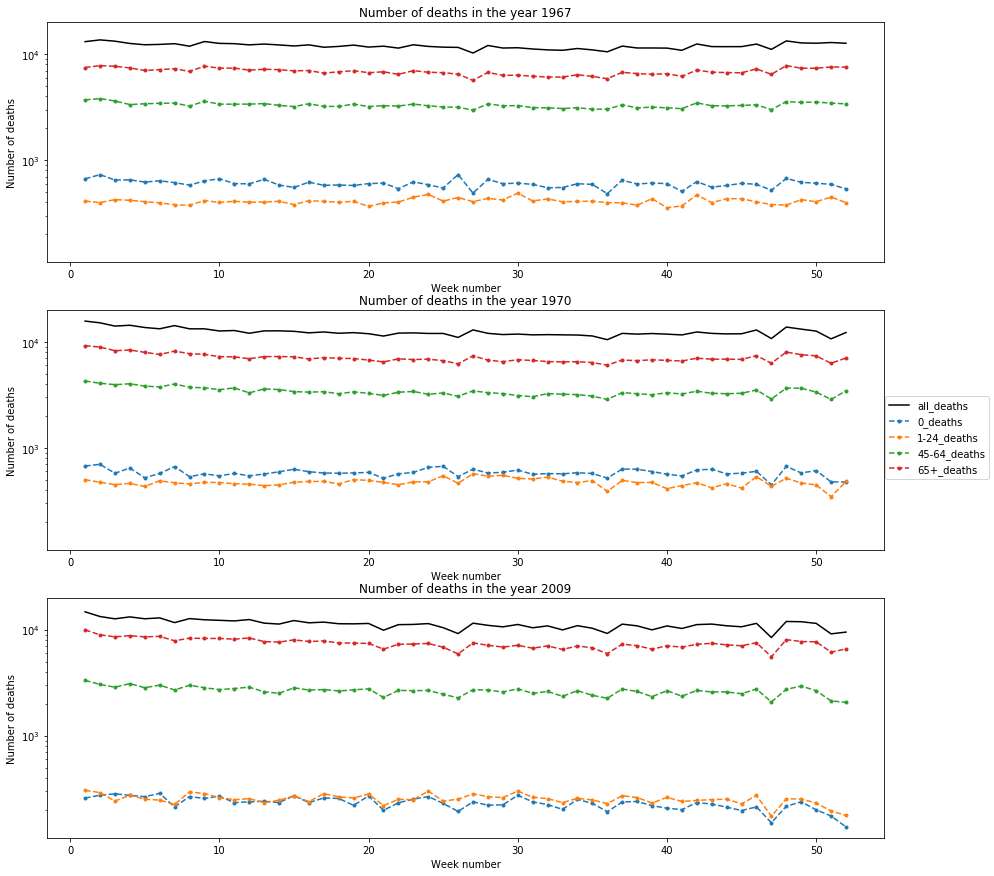

In [18]:
plot_total_deaths_per_week_by_year_compare([1967, 1970, 2009], ['PI_deaths', '25-44_deaths'])

### Plotting total deaths per year in a given city, possibly excluding some columns

In [19]:
def plot_total_deaths_per_year_by_city(city, exclude_age=[]):
    dc = dict_city[city].drop(columns=['check']).drop(columns=exclude_age).groupby(['year']).sum()
    fig, ax = plt.subplots()
    
    fig.set_size_inches(15,6)
    for col in dc.columns:
        if col == 'all_deaths':
            ax.plot(dc.index, dc[col], linestyle='-', color='black', label=col)
        elif col == 'PI_deaths':
            ax.plot(dc.index, dc[col], marker='', linestyle='-', color='red', label=col)
        else:
            ax.plot(dc.index, dc[col], linestyle='--', marker='.', label=col)

    ax.set(title='Number of deaths in {} between 1965 and 2016'.format(city), xlabel='Year', ylabel='Number of deaths')
    plt.yscale('log')
    fig.legend(loc='right')
    plt.show()

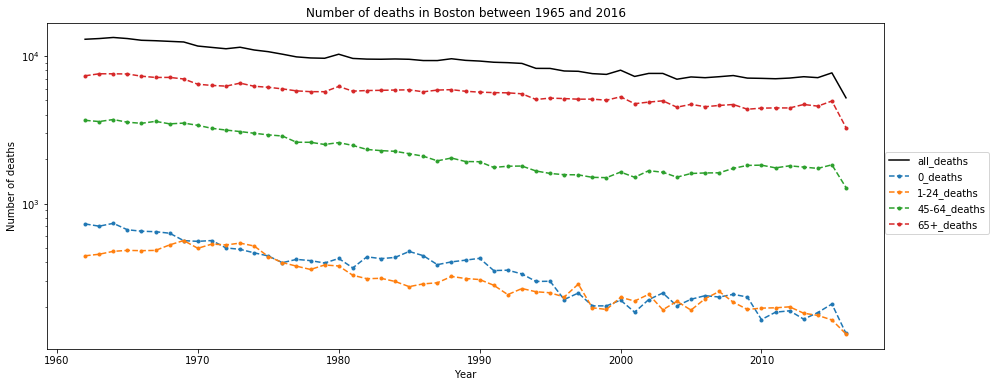

In [20]:
plot_total_deaths_per_year_by_city('Boston',['PI_deaths', '25-44_deaths'])

In [21]:
def plot_total_deaths_per_year_by_city_compare(cities=[], exclude_age=[]):
    if cities == []:
        print('The argument "cities" must be a non-empty list.')
    else:
        fig, ax = plt.subplots(len(cities),1, sharey=True)
        fig.set_size_inches(15,5*len(cities))
        
        for c in range(len(cities)):
            dc = dict_city[cities[c]].drop(columns=['check']).drop(columns=exclude_age).groupby(['year']).sum()
            for col in dc.columns:
                if col == 'all_deaths':
                    ax[c].plot(dc.index, dc[col], linestyle='-', color='black', label=col)
                elif col == 'PI_deaths':
                    ax[c].plot(dc.index, dc[col], marker='', linestyle='-', color='red', label=col)
                else:
                    ax[c].plot(dc.index, dc[col], linestyle='--', marker='.', label=col)

            ax[c].set(title='Number of deaths in {} between 1965 and 2016'.format(cities[c]), xlabel='Year', ylabel='Number of deaths')
            
        plt.yscale('log')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='right')

        plt.show()

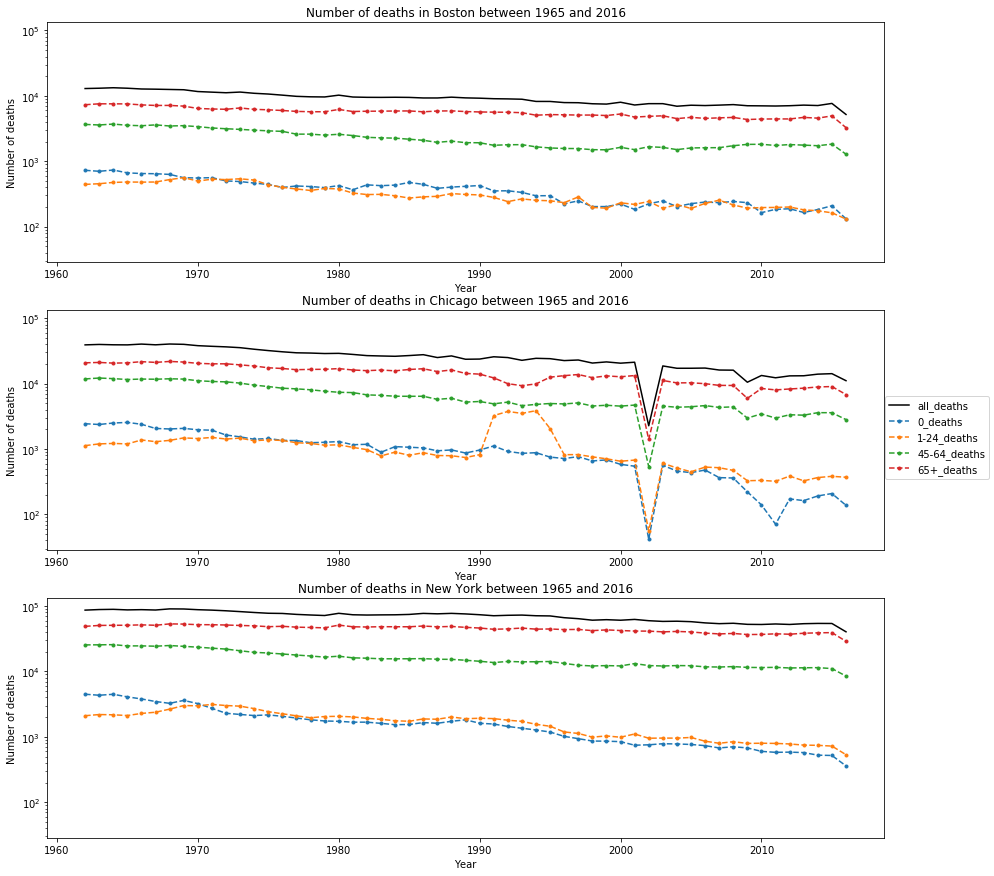

In [22]:
plot_total_deaths_per_year_by_city_compare(['Boston', 'Chicago', 'New York'], ['PI_deaths', '25-44_deaths'])

Chicago shows some funny trends to better analyse:
* 1991-1995 there are significantly more deaths in the 1-24 age group than before or after
* 2002 there's a very suspicious drop. Maybe some NaNs, although it's very consistent for all age groups. So maybe just an anomaly of some kind.